# Notebook 04: Modelado y Clasificación

**Prueba Técnica - Modelador Junior**

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, confusion_matrix, classification_report
import joblib
import warnings

# Configuración
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [2]:
df = pd.read_csv('../data/processed/dataset_final.csv')
df['date_requested'] = pd.to_datetime(df['date_requested'])
df['date_prediction'] = pd.to_datetime(df['date_prediction'])
print(f'Dataset: {df.shape}')

Dataset: (56, 33)


In [3]:
exclude = ['date_requested', 'date_prediction', 'direction_real', 'value_at_request', 'value_at_prediction']
X = df[[c for c in df.columns if c not in exclude]]
y = df['direction_real']
print(f'X: {X.shape}, y: {y.shape}')

X: (56, 28), y: (56,)


In [15]:
# Verificar valores nulos
print(f'Valores nulos en X: {X.isnull().sum().sum()}')

if X.isnull().sum().sum() > 0:
    print(f'Columnas con nulos: {X.isnull().sum()[X.isnull().sum() > 0].shape[0]}')  

# Split temporal (70% train, 30% test )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'Proporcion train/test: {len(X_train)/len(X):.1%} / {len(X_test)/len(X):.1%}')

Valores nulos en X: 0
Train: (39, 28), Test: (17, 28)
Proporcion train/test: 69.6% / 30.4%


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Scaled')

Scaled


## Logistic Regression

In [8]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

In [9]:
print('LOGISTIC REGRESSION')
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_lr, zero_division=0):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_lr, zero_division=0):.4f}')
print(f'F1: {f1_score(y_test, y_pred_lr, zero_division=0):.4f}')
try:
    print(f'R2: {r2_score(y_test, y_proba_lr):.4f}')
except:
    print('R2: N/A')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_lr))

LOGISTIC REGRESSION
Accuracy: 0.5833
Precision: 0.4000
Recall: 0.5000
F1: 0.4444
R2: -0.3395

Confusion Matrix:
[[5 3]
 [2 2]]


## Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

In [11]:
print('RANDOM FOREST')
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_rf, zero_division=0):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_rf, zero_division=0):.4f}')
print(f'F1: {f1_score(y_test, y_pred_rf, zero_division=0):.4f}')
try:
    print(f'R2: {r2_score(y_test, y_proba_rf):.4f}')
except:
    print('R2: N/A')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

RANDOM FOREST
Accuracy: 0.7500
Precision: 0.5714
Recall: 1.0000
F1: 0.7273
R2: 0.1649

Confusion Matrix:
[[5 3]
 [0 4]]


## Comparación y Selección

In [12]:
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
print(f'F1 LR: {f1_lr:.4f}')
print(f'F1 RF: {f1_rf:.4f}')
best = 'Random Forest' if f1_rf > f1_lr else 'Logistic Regression'
print(f'\nMejor modelo: {best}')

F1 LR: 0.4444
F1 RF: 0.7273

Mejor modelo: Random Forest


## Feature Importance - Top 5

In [13]:
if f1_rf > f1_lr:
    importances = rf.feature_importances_
    modelo_final = rf
else:
    importances = np.abs(lr.coef_[0])
    modelo_final = lr

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

print('\nTOP 5 FEATURES MÁS IMPORTANTES:')
for idx, row in feature_importance.head(5).iterrows():
    print(f'{idx+1}. {row["feature"]}: {row["importance"]:.4f}')


TOP 5 FEATURES MÁS IMPORTANTES:
1. avg_pct_change: 0.1251
2. AA6KBD_pct_change: 0.1164
3. avg_change: 0.1051
4. IPBG4J_change: 0.1044
5. IPBG4J_pct_change: 0.0839


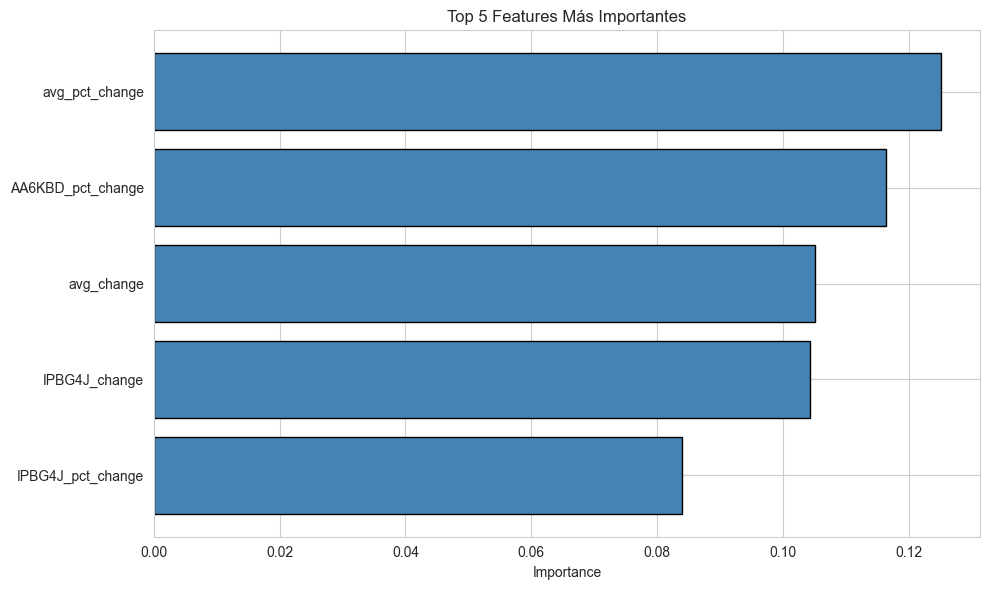

In [14]:
plt.figure(figsize=(10, 6))
top5 = feature_importance.head(5)
plt.barh(top5['feature'], top5['importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Top 5 Features Más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/figures/06_feature_importance.png', dpi=300)
plt.show()

In [ ]:
joblib.dump(modelo_final, '../data/results/modelo_final.pkl')
joblib.dump(scaler, '../data/results/scaler.pkl')
print('[OK] Modelo y scaler guardados correctamente')

[OK] Modelo, scaler e imputer guardados correctamente
